# Objective: Building a model that predicts flight delays a week in advance, using data from an SQL Database for US flights

As a first approach to the problem, we will limit the scope of the model to predicting delays in a single airline, DL. The first goal is to build a baseline simple model as a benchmark, to then subsequently improve upon iteratively. 

Because the size of the data was so unwieldly (around 15 million rows) we selected a sample of around 1 million rows for all months in 2019 to work with.

In [137]:
# import required packages
import numpy as np 
import pandas as pd
import psycopg2
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from features_adding import add_taxi_Ndays_rolling, add_traffic_rolling, replace_nan_with_mean

ImportError: cannot import name 'add_taxi_Ndays_rolling' from 'features_adding' (/Users/christiantruchsess/Documents/Professional/Programming/Lighthouse Labs/data_bootcamp/Mid_Term_Project/Predicting_Flight_Delays/features_adding.py)

## Data Extraction

Data was extracted to .csv files using a function found in the Postgres connection notebook. 

In [99]:
pd.set_option('display.max_columns', None)
flights_data = pd.read_csv('UA flights 2019.csv',parse_dates=[0])
flights_data = flights_data.sort_values(['fl_date'])

In [100]:
flights_data.head(2)

,fl_date,mkt_carrier,mkt_carrier_fl_num,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2019-01-01,UA,5611,N947SW,5611,14689,SBA,"Santa Barbara, CA",12892,LAX,"Los Angeles, CA",1915,1904.0,-11.0,12.0,1916.0,1942.0,12.0,2017,1954.0,-23.0,0.0,NaN,0.0,N,62.0,50.0,26.0,1.0,89.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2694,2019-01-01,UA,4902,N11181,4902,11618,EWR,"Newark, NJ",13485,MSN,"Madison, WI",918,925.0,7.0,21.0,946.0,1112.0,3.0,1106,1115.0,9.0,0.0,NaN,0.0,N,168.0,170.0,146.0,1.0,799.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will also connect to the database in order to extract any extra information we may need.

In [101]:
# connect to database and build query function
conn = psycopg2.connect(
    host="mid-term-project.ca2jkepgjpne.us-east-2.rds.amazonaws.com",
    database="mid_term_project",
    user="lhl_student",
    password="lhl_student")

def query(query):
    return pd.read_sql(query,conn)

## Data Preparation

Because the objective is to build a predictive model, not all the data features recorded in the (historical) flights table of the database would be available to the model at the moment of prediction.

Therefore, our training features have to correspond to the features that we would eventually have available to predict with.

In [102]:
training_features = query('SELECT * FROM flights_test LIMIT 1').columns.to_list()

In [103]:
training_features

['fl_date',
 'mkt_unique_carrier',
 'branded_code_share',
 'mkt_carrier',
 'mkt_carrier_fl_num',
 'op_unique_carrier',
 'tail_num',
 'op_carrier_fl_num',
 'origin_airport_id',
 'origin',
 'origin_city_name',
 'dest_airport_id',
 'dest',
 'dest_city_name',
 'crs_dep_time',
 'crs_arr_time',
 'dup',
 'crs_elapsed_time',
 'flights',
 'distance']

## Feature Engineering

A little bit of research will provide us with sufficient domain knowledge to be confident in our decisions when feature engineering:

(...)_we first define different terms that constitute the travel time segments: computerized reservation system (CRS) departure/arrival time is the scheduled departure/arrival time of the flight, wheels off is the time when the wheels of the aircraft leave the ground at the origin airport, and wheels on is the time when the wheels of the aircraft touch the ground at the destination airport. The departure delay of an aircraft is the difference between the actual departure time and the CRS departure time of the flight. Arrival delay equals actual arrival time minus the scheduled arrival time_(...)

source: https://stat-or.unc.edu/wp-content/uploads/sites/182/2018/09/Paper3_MSOM_2012_AirlineFlightDelays.pdf

We pick the features we want to keep from the "training_features" list extracted above. 

- We _keep_ `fl_date` (flight date) because the time of the year can potentially influence delays.
- We _remove_ `mkt_unique_carrier`,`branded_code_share`,`mkt_carrier`, `op_unique_carrier` (carrier identifiers) because we are dealing with a single airline anyways. 
- We _keep_ `mkt_carrier_fl_num` (flight number), because a specific flight might be recurringly problematic, therefore easy to predict delays for. 
- We _remove_ `tail_num` (aircraft identifier), because it is categorical and there are too many planes to turn it into dummy variables. 
- We _remove_ `op_carrier_fl_num` (flight number) because we already have `mkt_carrier_fl_num`.
- Our model will only look at origin airport and destination airport, identified by `origin_airport_id` and `dest_airport_id` respectively; the name of the airport, city or state is irrelevant, therefore we _remove_ `origin` (name of airport), `origin_city_name` (origin airport and city name), `dest` and `dest_city_name`.
- We _keep_ `crs_dep_time`, `crs_arr_time` and `crs_elapsed_time` (scheduled departure, arrival and time of flight) because they are our reference points in time; flights scheduled for busy times in the day might be more susceptible to delays.
- We _remove_ `dup` and `flights` because they provide us no information (same value for all rows, N and 1 respectively).
- We _keep_ arr_delay because it is our target variable

In [104]:
removal_list = ['mkt_unique_carrier','branded_code_share','mkt_carrier','op_unique_carrier','op_carrier_fl_num','tail_num','origin','origin_city_name','dest','dest_city_name','dup','flights']
training_features = [ x for x in training_features if x not in removal_list]
training_features.append('arr_delay')
training_features

['fl_date',
 'mkt_carrier_fl_num',
 'origin_airport_id',
 'dest_airport_id',
 'crs_dep_time',
 'crs_arr_time',
 'crs_elapsed_time',
 'distance',
 'arr_delay']

Now that we have reduced the features we are going to work with, we proceed to clean up our dataframe. First, we will check our data types. 

In [105]:
flights_data = flights_data[training_features]
flights_data.dtypes

fl_date               datetime64[ns]
mkt_carrier_fl_num             int64
origin_airport_id              int64
dest_airport_id                int64
crs_dep_time                   int64
crs_arr_time                   int64
crs_elapsed_time             float64
distance                     float64
arr_delay                    float64
dtype: object

Convert datetime objects to integers:

In [106]:
flights_data['fl_date'] = flights_data['fl_date'].map(dt.datetime.toordinal)
flights_data.dtypes

fl_date                 int64
mkt_carrier_fl_num      int64
origin_airport_id       int64
dest_airport_id         int64
crs_dep_time            int64
crs_arr_time            int64
crs_elapsed_time      float64
distance              float64
arr_delay             float64
dtype: object

Check for NaN values:

In [107]:
flights_data.isna().sum()

fl_date                   0
mkt_carrier_fl_num        0
origin_airport_id         0
dest_airport_id           0
crs_dep_time              0
crs_arr_time              0
crs_elapsed_time          9
distance                  0
arr_delay             42491
dtype: int64

In [108]:
flights_data.shape

(1571404, 9)

In [109]:
(42491/1571404)*100

2.7040150082346743

Let's take a look at the arr_delay data, to see what we should do with those NaN values:

In [110]:
flights_data['arr_delay'].describe()

count    1.528913e+06
mean     1.067793e+01
std      6.588224e+01
min     -9.100000e+01
25%     -1.600000e+01
50%     -6.000000e+00
75%      1.100000e+01
max      1.909000e+03
Name: arr_delay, dtype: float64

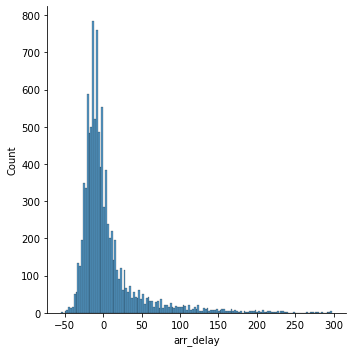

In [111]:
sns.displot(flights_data[flights_data['arr_delay'] < 300]['arr_delay'].sample(n=10000))

Calculating the IQR range, and calculating the mean without taking outliers into consideration:

In [112]:
IQR_arr_delay = float(flights_data['arr_delay'].describe()[6] - flights_data['arr_delay'].describe()[4])
outlier_threshold = 1.5 * IQR_arr_delay
lower_threshold = (flights_data['arr_delay'].describe()[4]) - outlier_threshold
upper_threshold = (flights_data['arr_delay'].describe()[6]) + outlier_threshold

In [113]:
mean_without_outliers = flights_data[(flights_data['arr_delay'] > lower_threshold) & (flights_data['arr_delay'] < upper_threshold)]['arr_delay'].mean()
mean_without_outliers

-5.045717239937962

Let's replace missing value with the mean previously found. 

In [133]:
def replace_nan_with_mean(dataframe,column):
    """
    This function replaces all NaN values for a given column in a dataframe with the mean of the column values,
        _without_ taking outliers into consideration when calculating said mean.
    Args:
        dataframe - Pandas DataFrame 
        column - column of DataFrame, input as a string. 
    Output:
        Processed DataFrame is returned.
    """
    # The .describe() method for Pandas DataFrames outputs a Pandas Series; index number 4 corresponds to 
    # Quartile 1, index number 6 to Quartile 3. The Inter-Quartile Range (IQR) is then calculated as Q3 - Q1.
    Q1 = dataframe[column].describe()[4]
    Q3 = dataframe[column].describe()[6]
    IQR = float(Q3 - Q1)
    # An outlier threshold is calculated as 1.5 times the IQR. Any value that is below Q1 minus the threshold,
    # or above Q3 plus the threshold, is considered an outlier. 
    outlier_threshold = 1.5 * IQR
    lower_limit = Q1 - outlier_threshold
    upper_limit = Q3 + outlier_threshold
    
    # Use boolean operators to define subset of column values that exclude outliers
    subset_without_outliers = dataframe[(dataframe[column] > lower_limit) & (dataframe[column] < upper_limit)][column]
    
    # Calculate the mean for said subset. 
    mean_without_outliers = subset_without_outliers.mean()
     
    # Replace NaN values with previously calculated mean, using .fillna() Pandas method.
    dataframe = dataframe.fillna(mean_without_outliers,inplace=True)
    
    # Return processed DataFrame
    return dataframe

In [134]:
replace_nan_with_mean(flights_data,'arr_delay')
flights_data.isna().sum()

fl_date               0
mkt_carrier_fl_num    0
origin_airport_id     0
dest_airport_id       0
crs_dep_time          0
crs_arr_time          0
crs_elapsed_time      0
distance              0
arr_delay             0
dtype: int64

In [120]:
X = flights_data[training_features]
y = flights_data['arr_delay']

In [121]:
X.tail(3)

,fl_date,mkt_carrier_fl_num,tail_num,origin_airport_id,dest_airport_id,crs_dep_time,crs_arr_time,crs_elapsed_time,distance
1568914,2019-12-31,3536,N732YX,11278,11618,1955,2130,95.0,199.0
1568902,2019-12-31,3523,N650RW,11618,13198,1110,1346,216.0,1092.0
1571403,2019-12-31,3765,N416AW,13930,10408,1405,1514,69.0,161.0


In [122]:
X.shape

(1571404, 9)

Check for null values

In [123]:
X.isna().sum()

fl_date                   0
mkt_carrier_fl_num        0
tail_num              15775
origin_airport_id         0
dest_airport_id           0
crs_dep_time              0
crs_arr_time              0
crs_elapsed_time          9
distance                  0
dtype: int64

In [130]:
X = X.dropna(axis=0,subset=['tail_num'])

In [131]:
X.isna().sum()

fl_date               0
mkt_carrier_fl_num    0
tail_num              0
origin_airport_id     0
dest_airport_id       0
crs_dep_time          0
crs_arr_time          0
crs_elapsed_time      2
distance              0
dtype: int64

In [124]:
y.isna().sum()

42491

In [132]:
y

0         -23.0
2694        9.0
2695      -15.0
2696      -17.0
2697        0.0
           ... 
1568912     3.0
1568913   -21.0
1568914   -24.0
1568902   -29.0
1571403    27.0
Name: arr_delay, Length: 1571404, dtype: float64

Instantiate our model:

In [137]:
linreg = LinearRegression()

In [142]:
linreg.fit(X_train,y_train)

TypeError: invalid type promotion